# Coursework IDA

## Task 1

## 1.1. 
Implement and train a method for automatically classifying texts in the FiQA sentiment analysis
dataset as positive, neutral or negative. Refer to the labs, lecture materials and textbook to identify
a suitable method. In your report:
• Briefly explain how your chosen method works and its main strengths and limitations;
• Describe the preprocessing steps and the features you use to represent each text instance;
• Explain why you chose those features and preprocessing steps and hypothesise how they
will affect your results;
• Briefly describe your software implementation.
(10 marks)



In [1]:
%load_ext autoreload
%autoreload 2

# Use HuggingFace's datasets library to access the financial_phrasebank dataset
from datasets import load_dataset
import pandas as pd
import numpy as np
import json

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score, classification_report

from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *

# pre trained analyser for comparison
from nltk.sentiment import SentimentIntensityAnalyzer

import matplotlib.pyplot as plt

# for negation
import re


In [2]:
train_files = [
    'data_cache/FiQA_ABSA_task1/task1_headline_ABSA_train.json',
    'data_cache/FiQA_ABSA_task1/task1_post_ABSA_train.json'
]

In [4]:


def load_fiqa_sa_from_json(json_files):
    train_text = []
    train_labels = []

    # iterate through each tweet file
    for file in json_files:
        # open file in read mode, with method closes file after getting data stream
        with open(file, 'r', encoding = 'utf8') as handle:
            # load file object and convert into json object
            dataf = json.load(handle)
        
        
        dataf_text = [dataf[k]["sentence"] for k in dataf.keys()]
        # print(len(dataf_text))
        train_text.extend(dataf_text)

        dataf_labels = [float(dataf[k]["info"][0]["sentiment_score"]) for k in dataf.keys()]
        # print(len(dataf_labels))
        train_labels.extend(dataf_labels)

    train_text = np.array(train_text)
    train_labels = np.array(train_labels)
    
    return train_text, train_labels


def threshold_scores(scores):
    """
    Convert sentiment scores to discrete labels.
    0 = negative.
    1 = neutral.
    2 = positive.
    """
    labels = []
    for score in scores:
        if score < -0.2:
            labels.append(0)
        elif score > 0.2:
            labels.append(2)
        else:
            labels.append(1)
            
    return np.array(labels)


all_text, all_labels = load_fiqa_sa_from_json(train_files)
    
print(f'Number of instances: {len(all_text)}')
print(f'Number of labels: {len(all_labels)}')

all_labels = threshold_scores(all_labels)
print(f'Number of negative labels: {np.sum(all_labels==0)}')
print(f'Number of neutral labels: {np.sum(all_labels==1)}')
print(f'Number of positive labels: {np.sum(all_labels==2)}')

FileNotFoundError: [Errno 2] No such file or directory: 'data_cache/FiQA_ABSA_task1/task1_headline_ABSA_train.json'

In [117]:
print(all_labels[0])

0


In [118]:
type(load_fiqa_sa_from_json(train_files))

tuple

In [119]:
print(len(load_fiqa_sa_from_json(train_files)[0]))

1111


In [120]:

# Split test data from training data
train_documents, test_documents, train_labels, test_labels = train_test_split(
    all_text, 
    all_labels, 
    test_size=0.2, 
    stratify=all_labels  # make sure the same proportion of labels is in the test set and training set
)

# Split validation data from training data
train_documents, val_documents, train_labels, val_labels = train_test_split(
    train_documents, 
    train_labels, 
    test_size=0.15, 
    stratify=train_labels  # make sure the same proportion of labels is in the test set and training set
)

print(f'Number of training instances = {len(train_documents)}')
print(f'Number of validation instances = {len(val_documents)}')
print(f'Number of test instances = {len(test_documents)}')


Number of training instances = 754
Number of validation instances = 134
Number of test instances = 223


In [121]:
print(f'What does one instance look like from the training set? \n\n{train_documents[233]}')
print(f'...and here is its corresponding label \n\n{train_labels[233]}')

What does one instance look like from the training set? 

$PCLN Trying to break daily trend line! Big move could happen https://t.co/gY0aDb2jsQ https://t.co/KPBBCgQ2xy
...and here is its corresponding label 

2


In [122]:


# CountVectorizer can do its own tokenization, but for consistency we want to
# carry on using WordNetTokenizer. We write a small wrapper class to enable this:
class Tokenizer(object):
    def __call__(self, tweets):
        return word_tokenize(tweets)

    
# create stopwords function from nltk
stop_words = set(stopwords.words('english'))
vectorizer = CountVectorizer(tokenizer=Tokenizer())  # construct the vectorizer
# with stop word removal
#vectorizer = CountVectorizer(tokenizer=Tokenizer(), stop_words=stop_words)  # construct the vectorizer

vectorizer.fit(train_documents)  # Learn the vocabulary
X_train = vectorizer.transform(train_documents)  # extract training set bags of words
X_val = vectorizer.transform(val_documents)  # extract test set bags of words
X_test = vectorizer.transform(test_documents)  # extract test set bags of words

C:\Users\loz\anaconda3\envs\data_analytics\lib\site-packages\sklearn\feature_extraction\text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [123]:
# print(nltk.data.path)

In [124]:
# see count vector from training set
counts = pd.DataFrame(X_train.toarray(), columns = vectorizer.get_feature_names_out())

In [125]:
X_train

<754x3292 sparse matrix of type '<class 'numpy.int64'>'
	with 10343 stored elements in Compressed Sparse Row format>

In [126]:
counts.columns


Index(['!', '#', '$', '%', '&', ''', '''', ''15', ''best', ''breached',
       ...
       '}', '~', '~100pt', '~4.2', 'â£100m', 'â£180m', 'â£30m', 'â£347',
       'â£90m', '”'],
      dtype='object', length=3292)

## 1.2. Evaluate Method

Evaluate your method, then interpret and discuss your results. Include the following points:
• Define your performance metrics and state their limitations;
• Describe the testing procedure (e.g., how you used each split of the dataset);
• Show your results using suitable plots or tables;
• How could you improve the method or experimental process? Consider the errors that your
method makes.
(9 marks)


## Naive Bayes Classifier

In [127]:
# initialise and fit classifier
classifier = MultinomialNB()
classifier.fit(X_train, train_labels)

MultinomialNB()

In [128]:
y_val_pred = classifier.predict(X_val)

In [129]:
cm = metrics.confusion_matrix(val_labels, y_val_pred)


In [130]:
# Define class labels
classes = ['0', '1', '2']


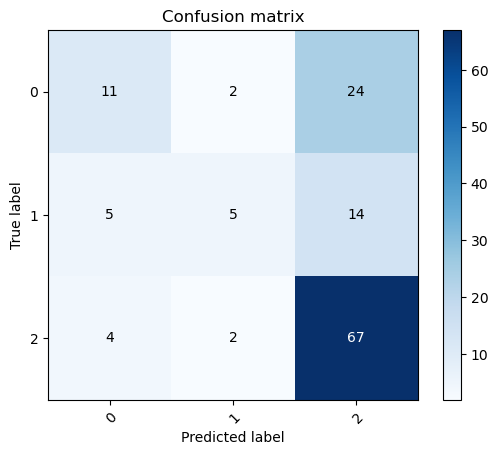

In [131]:
# Plot confusion matrix
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes, yticklabels=classes,
       xlabel='Predicted label', ylabel='True label',
       title='Confusion matrix')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Add counts to each cell
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > cm.max() / 2. else "black")

# Show plot
plt.show()

In [132]:
# We can get all of these with a per-class breakdown using classification_report:
print(classification_report(val_labels, y_val_pred))

              precision    recall  f1-score   support

           0       0.55      0.30      0.39        37
           1       0.56      0.21      0.30        24
           2       0.64      0.92      0.75        73

    accuracy                           0.62       134
   macro avg       0.58      0.47      0.48       134
weighted avg       0.60      0.62      0.57       134



In [133]:
vocabulary = vectorizer.vocabulary_

### CHANGE THE NAME OF THE CLASSIFIER VARIABLE BELOW TO USE YOUR TRAINED CLASSIFIER
feat_likelihoods = np.exp(classifier.feature_log_prob_)  # Use exponential to convert the logs back to probabilities
###

# WRITE YOUR CODE HERE
print(feat_likelihoods[:, vocabulary['a']])
print(feat_likelihoods[:, vocabulary['it']])

[0.00481516 0.0032749  0.00822825]
[0.0027959  0.00250433 0.00224407]


# Logistic Regression Classifier

In [134]:
classifier = LogisticRegression()
classifier.fit(X_train, train_labels)

LogisticRegression()

In [135]:
y_val_pred = classifier.predict(X_val)

In [136]:
cm = metrics.confusion_matrix(val_labels, y_val_pred)


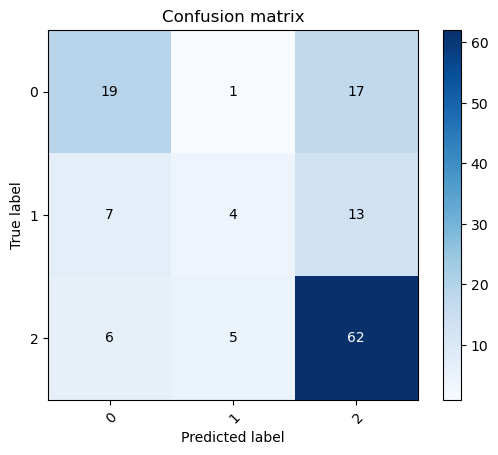

In [137]:

# Define class labels
classes = ['0', '1', '2']

# Plot confusion matrix
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes, yticklabels=classes,
       xlabel='Predicted label', ylabel='True label',
       title='Confusion matrix')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Add counts to each cell
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > cm.max() / 2. else "black")

# Show plot
plt.show()

In [138]:


# We can get all of these with a per-class breakdown using classification_report:
print(classification_report(val_labels, y_val_pred))

              precision    recall  f1-score   support

           0       0.59      0.51      0.55        37
           1       0.40      0.17      0.24        24
           2       0.67      0.85      0.75        73

    accuracy                           0.63       134
   macro avg       0.56      0.51      0.51       134
weighted avg       0.60      0.63      0.60       134



## With Data Processing

In [140]:
def add_negation(sentence):
    # define regex pattern to match words after "not", "n't", or "never"
    pattern = r"(?:(?:(?:not)|(?:n't)|(?:never))\s+)(\w+)"
    
    # use regex to find and replace words with negation prefix
    result = re.sub(pattern, r" not_\1", sentence)
    
    return result

In [141]:
# apply add_negation to each tweet in the array using a list comprehension
all_text_negated = np.array([add_negation(text) for text in all_text])


In [142]:
# convert all tweets to lower case
all_text_negated = np.char.lower(all_text_negated)

In [143]:

# Split test data from training data
train_documents, test_documents, train_labels, test_labels = train_test_split(
    all_text_negated, 
    all_labels, 
    test_size=0.2, 
    stratify=all_labels,  # make sure the same proportion of labels is in the test set and training set
    random_state= 43
)

# Split validation data from training data
train_documents, val_documents, train_labels, val_labels = train_test_split(
    train_documents, 
    train_labels, 
    test_size=0.15, 
    stratify=train_labels,  # make sure the same proportion of labels is in the test set and training set
    random_state= 43
)

print(f'Number of training instances = {len(train_documents)}')
print(f'Number of validation instances = {len(val_documents)}')
print(f'Number of test instances = {len(test_documents)}')


Number of training instances = 754
Number of validation instances = 134
Number of test instances = 223


In [144]:
print(f'What does one instance look like from the training set? \n\n{train_documents[233]}')
print(f'...and here is its corresponding label \n\n{train_labels[233]}')

What does one instance look like from the training set? 

gsk joins china trade push as uk trumpets healthcare deals
...and here is its corresponding label 

2


In [145]:


# CountVectorizer can do its own tokenization, but for consistency we want to
# carry on using WordNetTokenizer. We write a small wrapper class to enable this:
class Tokenizer(object):
    def __call__(self, tweets):
        return word_tokenize(tweets)

    
# create stopwords function from nltk
stop_words = set(stopwords.words('english'))
#vectorizer = CountVectorizer(tokenizer=Tokenizer())  # construct the vectorizer

# with stop word removal
vectorizer = CountVectorizer(tokenizer=Tokenizer(), stop_words=stop_words)  # construct the vectorizer

vectorizer.fit(train_documents)  # Learn the vocabulary
X_train = vectorizer.transform(train_documents)  # extract training set bags of words
X_val = vectorizer.transform(val_documents)  # extract test set bags of words
X_test = vectorizer.transform(test_documents)  # extract test set bags of words

C:\Users\loz\anaconda3\envs\data_analytics\lib\site-packages\sklearn\feature_extraction\text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\loz\anaconda3\envs\data_analytics\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn(


In [146]:
# see count vector from training set
counts = pd.DataFrame(X_train.toarray(), columns = vectorizer.get_feature_names_out())

In [147]:
X_train

<754x3208 sparse matrix of type '<class 'numpy.int64'>'
	with 8346 stored elements in Compressed Sparse Row format>

In [148]:
counts.columns


Index(['!', '#', '$', '%', '&', ''', '''', ''15', ''best', ''challenging',
       ...
       'â£100m', 'â£22', 'â£250m', 'â£30m', 'â£347', 'â€', '’', '“', '”', '📈'],
      dtype='object', length=3208)

## Naive Bayes Classifier With Data Processing

In [149]:
# WRITE YOUR CODE HERE
classifier = MultinomialNB()
classifier.fit(X_train, train_labels)

MultinomialNB()

In [150]:
y_val_pred = classifier.predict(X_val)

In [151]:
cm = metrics.confusion_matrix(val_labels, y_val_pred)


In [152]:
# Define class labels
classes = ['0', '1', '2']


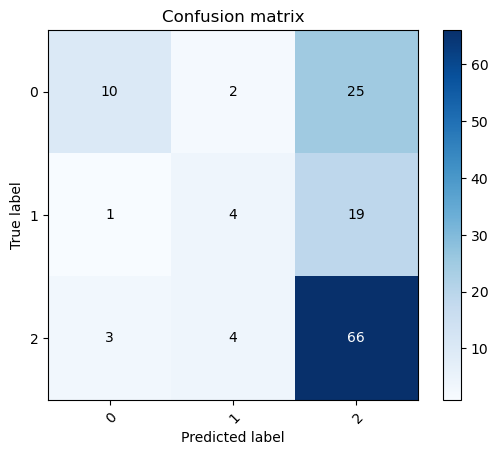

In [153]:
# Plot confusion matrix
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes, yticklabels=classes,
       xlabel='Predicted label', ylabel='True label',
       title='Confusion matrix')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Add counts to each cell
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > cm.max() / 2. else "black")

# Show plot
plt.show()

In [154]:


# We can get all of these with a per-class breakdown using classification_report:
print(classification_report(val_labels, y_val_pred))

              precision    recall  f1-score   support

           0       0.71      0.27      0.39        37
           1       0.40      0.17      0.24        24
           2       0.60      0.90      0.72        73

    accuracy                           0.60       134
   macro avg       0.57      0.45      0.45       134
weighted avg       0.60      0.60      0.54       134



In [155]:
vocabulary = vectorizer.vocabulary_

### CHANGE THE NAME OF THE CLASSIFIER VARIABLE BELOW TO USE YOUR TRAINED CLASSIFIER
feat_likelihoods = np.exp(classifier.feature_log_prob_)  # Use exponential to convert the logs back to probabilities
###

# WRITE YOUR CODE HERE
#print(feat_likelihoods[:, vocabulary['a']])
#print(feat_likelihoods[:, vocabulary['it']])

# Logistic Regression Classifier With Data Processing



In [156]:


classifier = LogisticRegression()
classifier.fit(X_train, train_labels)

LogisticRegression()

In [157]:
y_val_pred = classifier.predict(X_val)

In [158]:
cm = metrics.confusion_matrix(val_labels, y_val_pred)


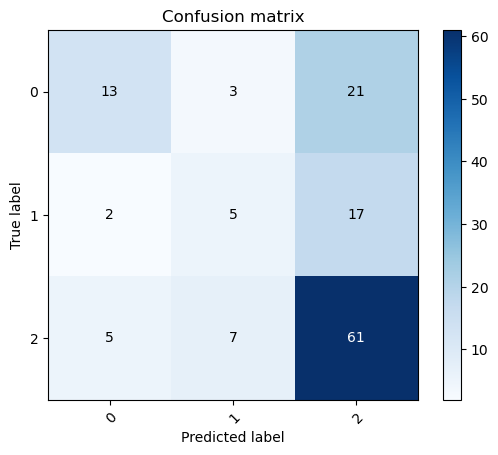

In [159]:

# Define class labels
classes = ['0', '1', '2']

# Plot confusion matrix
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes, yticklabels=classes,
       xlabel='Predicted label', ylabel='True label',
       title='Confusion matrix')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Add counts to each cell
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > cm.max() / 2. else "black")

# Show plot
plt.show()

In [163]:


# We can get all of these with a per-class breakdown using classification_report:
print(classification_report(val_labels, y_val_pred))

              precision    recall  f1-score   support

           0       0.65      0.35      0.46        37
           1       0.33      0.21      0.26        24
           2       0.62      0.84      0.71        73

    accuracy                           0.59       134
   macro avg       0.53      0.47      0.47       134
weighted avg       0.57      0.59      0.56       134



# 1.3 Common Themes & Topics

1.3. Can you identify common themes or topics associated with negative sentiment or positive
sentiment in this dataset?
• Explain the method you use to identify themes or topics;
• Show your results (e.g., by listing or visualising example topics or themes);
• Interpret the results and summarise the limitations of your approach.
(12 marks) 

In [164]:
n_feats_to_show = 10

# Flip the index so that values are keys and keys are values:
keys = vectorizer.vocabulary_.values()
values = vectorizer.vocabulary_.keys()
vocab_inverted = dict(zip(keys, values))

for c, weights_c in enumerate(classifier.coef_):
    print(f'\nWeights for class {c}:\n')
    strongest_idxs = np.argsort(weights_c)[-n_feats_to_show:]

    for idx in strongest_idxs:
        print(f'{vocab_inverted[idx]} with weight {weights_c[idx]}')


Weights for class 0:

downside with weight 0.5875998110987003
fall with weight 0.5916908531206638
slides with weight 0.5935672604996814
drops with weight 0.6163783512284116
worries with weight 0.6179292276296745
falls with weight 0.626151834152553
lower with weight 0.7044753712571077
bearish with weight 0.7853758213015406
spy with weight 0.8209886063070098
short with weight 1.0916704347579802

Weights for class 1:

inbev with weight 0.600196002060194
boss with weight 0.6188869229095497
pressure with weight 0.619961324927741
yet with weight 0.6487119932543988
volatility with weight 0.6616673310672513
? with weight 0.668479826552734
board with weight 0.6782649062182187
right with weight 0.7244310793234664
rt with weight 0.7430912052790485
ceo with weight 1.1422591490447898

Weights for class 2:

calls with weight 0.5935583267389843
offer with weight 0.6025150107273753
run with weight 0.6632407929756554
buys with weight 0.6869087268690418
growth with weight 0.6872874623663082
unit with w

### Topics

In [165]:
pos_index = all_labels == 2  # compare predictions to gold labels
neg_index = all_labels == 0  # compare predictions to gold labels
# get the text of tweets where the classifier made an error:
pos_tweets = np.array(all_text)[pos_index]
neg_tweets = np.array(all_text)[neg_index]

In [166]:
#type(pos_tweets)
print(pos_tweets[0])
print(neg_tweets[0])

Primark racks up a happy Christmas after strong sales
Royal Mail chairman Donald Brydon set to step down


In [167]:
processed_pos = []
processed_neg = []

In [168]:
from nltk.stem import WordNetLemmatizer 
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS # find stopwords

np.random.seed(400)  # We fix the random seed to ensure we get consistent results when we repeat the lab.

# Tokenize and lemmatize
def preprocess(text):
    result=[]
    for token in simple_preprocess(text) :  # Tokenize, remove very short and very long words, convert to lower case, remove words containing non-letter characters
        if token not in STOPWORDS:
            result.append(WordNetLemmatizer().lemmatize(token, 'v'))
            
    return result

# Create lists of preprocessed documents
for tweet in pos_tweets:
    processed_pos.append(preprocess(tweet))
    
for tweet in neg_tweets:
    processed_neg.append(preprocess(tweet))

In [169]:
# nltk.download('wordnet')

In [170]:
print(processed_pos[0])
print(processed_neg[0])

['primark', 'rack', 'happy', 'christmas', 'strong', 'sales']
['royal', 'mail', 'chairman', 'donald', 'brydon', 'set', 'step']


In [171]:
from gensim.corpora import Dictionary

dictionary_pos = Dictionary(processed_pos) # construct word<->id mappings - it does it in alphabetical order
print(dictionary_pos)

pos_bow_corpus = [dictionary_pos.doc2bow(tweet) for tweet in processed_pos]

dictionary_neg = Dictionary(processed_neg) # construct word<->id mappings - it does it in alphabetical order
print(dictionary_neg)

neg_bow_corpus = [dictionary_neg.doc2bow(tweet) for tweet in processed_neg]

Dictionary(2016 unique tokens: ['christmas', 'happy', 'primark', 'rack', 'sales']...)
Dictionary(1243 unique tokens: ['brydon', 'chairman', 'donald', 'mail', 'royal']...)


In [172]:
len(pos_bow_corpus)

606

In [173]:
len(neg_bow_corpus)

310

In [174]:
from gensim.models import LdaModel

lda_pos_model =  LdaModel(pos_bow_corpus, 
                      num_topics=10, 
                      id2word=dictionary_pos,                                    
                      passes=10,
                    ) 

lda_neg_model =  LdaModel(neg_bow_corpus, 
                      num_topics=10, 
                      id2word=dictionary_neg,                                    
                      passes=10,
                    ) 

In [175]:
'''
For each topic, we will explore the words occuring in that topic and its relative weight
'''
for idx, topic in lda_pos_model.print_topics(-1):
    print("Pos Topic: {} \nWords: {}".format(idx, topic ))
    print("\n")
    
for idx, topic in lda_neg_model.print_topics(-1):
    print("Neg Topic: {} \nWords: {}".format(idx, topic ))
    print("\n")

Pos Topic: 0 
Words: 0.021*"https" + 0.015*"buy" + 0.013*"time" + 0.012*"earn" + 0.011*"today" + 0.011*"long" + 0.009*"ftse" + 0.008*"share" + 0.007*"breakout" + 0.007*"bbry"


Pos Topic: 1 
Words: 0.017*"stks" + 0.017*"http" + 0.015*"higher" + 0.012*"https" + 0.010*"long" + 0.010*"high" + 0.008*"price" + 0.007*"year" + 0.007*"like" + 0.006*"share"


Pos Topic: 2 
Words: 0.016*"buy" + 0.010*"sales" + 0.010*"http" + 0.010*"stks" + 0.010*"share" + 0.009*"price" + 0.009*"astrazeneca" + 0.008*"tesco" + 0.008*"close" + 0.008*"plc"


Pos Topic: 3 
Words: 0.012*"sell" + 0.012*"buy" + 0.011*"astrazeneca" + 0.010*"day" + 0.009*"aapl" + 0.009*"update" + 0.007*"arm" + 0.005*"https" + 0.005*"good" + 0.005*"bank"


Pos Topic: 4 
Words: 0.025*"http" + 0.024*"stks" + 0.017*"long" + 0.011*"https" + 0.010*"break" + 0.009*"look" + 0.009*"aapl" + 0.009*"buy" + 0.008*"share" + 0.007*"dividend"


Pos Topic: 5 
Words: 0.020*"http" + 0.020*"stks" + 0.015*"call" + 0.011*"share" + 0.008*"aapl" + 0.008*"rise" +

### Individual Topic Distribution

In [176]:
test_document_idx = 10
unseen_document = pos_tweets[test_document_idx]
print(unseen_document)

#print(f' This document is from newsgroup {newsgroups_test.target_names[newsgroups_test.target[test_document_idx]]}')

# Data preprocessing step for the unseen document - It is the same preprocessing we have performed for the training data
bow_vector = dictionary.doc2bow(preprocess(unseen_document))

for idx, count in bow_vector:
    print(f'{dictionary[idx]}: {count}')

FDA approves Shire's Vyvanse for binge-eating disorder


NameError: name 'dictionary' is not defined

In [ ]:
topic_distribution = lda_model[bow_vector]

for index, probability in sorted(topic_distribution, key=lambda tup: -1*tup[1]):
    print("Index: {}\nProbability: {}\t Topic: {}".format(index, probability, lda_model.print_topic(index, 5)))

In [ ]:
# make list of tuples ready for model training

train_set = list(zip(list_a, list_b))

## Task 2: Named Entity Recognition (max. 19%)  

In scientific research, information extraction can help researchers to discover relevant findings from
across a wide body of literature. As a first step, your task is to build a tool for named entity
recognition in scientific journal article abstracts. We will be working with the BioNLP 2004 dataset of
abstracts from MEDLINE, a database containing journal articles from fields including medicine and
pharmacy. The data was collected by searching for the terms ‘human’, ‘blood cells’ and
‘transcription factors’, and then annotated with five entity types: DNA, protein, cell type, cell line,
RNA. 

More information can be found in the paper: https://aclanthology.org/W04-1213.pdf .
We provide a cache of the data and code for loading the data in ‘data_loader_demo’ in our Github
repository, https://github.com/uob-TextAnalytics/intro-labs-public. This script downloaded the data
from HuggingFace, where you can also find more information about the dataset:
https://huggingface.co/datasets/tner/bionlp2004 .


The data is presented in this paper:
Nigel Collier, Tomoko Ohta, Yoshimasa Tsuruoka, Yuka Tateisi, and Jin-Dong Kim. 2004. Introduction
to the Bio-entity Recognition Task at JNLPBA. In Proceedings of the International Joint Workshop on
Natural Language Processing in Biomedicine and its Applications (NLPBA/BioNLP), pages 73–78,
Geneva, Switzerland. COLING.